In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [3]:
df_cash_request = pd.read_csv("/kaggle/input/bank-customers/extract - cash request - data analyst.csv")
df_fees = pd.read_csv("/kaggle/input/bank-customers/extract - fees - data analyst - .csv")

In [4]:
plt.figure(figsize=(10,8))
fig1= px.imshow(df_cash_request.isnull(), 
                color_continuous_scale=['black', 'red'],
                labels=dict(color="NaN"),
                title="Color map for cash_request")
fig1.update_layout(width=700, height=700)
fig1.update_coloraxes(showscale=False)
fig1.show()

<Figure size 1000x800 with 0 Axes>

In [5]:
plt.figure(figsize=(10,8))
fig1= px.imshow(df_fees.isnull(), 
                color_continuous_scale=['black', 'red'],
                labels=dict(color="NaN"),
                title="Color map for fees")
fig1.update_layout(width=700, height=700)
fig1.update_coloraxes(showscale=False)
fig1.show()

<Figure size 1000x800 with 0 Axes>

In [6]:
df_cash_request.describe()

,id,amount,user_id,deleted_account_id
count,23970.000000,23970.000000,21867.000000,2104.000000
mean,13910.966124,82.720818,32581.250789,9658.755228
std,7788.117214,26.528065,27618.565773,7972.743249
min,3.000000,1.000000,34.000000,91.000000
25%,7427.250000,50.000000,10804.000000,3767.000000
50%,14270.500000,100.000000,23773.000000,6121.500000
75%,20607.750000,100.000000,46965.000000,16345.000000
max,27010.000000,200.000000,103719.000000,30445.000000


In [7]:
df_cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [8]:
df_fees.describe()

,id,cash_request_id,total_amount
count,21061.000000,21057.000000,21061.000000
mean,10645.355111,16318.449162,5.000237
std,6099.315256,6656.149949,0.034453
min,1.000000,1456.000000,5.000000
25%,5385.000000,11745.000000,5.000000
50%,10652.000000,17160.000000,5.000000
75%,15925.000000,21796.000000,5.000000
max,21193.000000,27010.000000,10.000000


In [9]:
df_fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [10]:
df = df_fees.merge(df_cash_request, left_on='cash_request_id', right_on='id', how='inner')

In [11]:
df.head()

,id_x,cash_request_id,type,status_x,category,total_amount,reason,created_at_x,updated_at_x,paid_at,...,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,...,NaN,NaN,2020-10-01 22:00:00+00,NaN,2020-10-06 22:00:00+00,instant,2020-09-14 10:46:57.735172+00,pending,2020-10-11 22:52:52.274832+00,2020-12-20 22:40:42.556534+00
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,...,2020-08-10 14:58:19.039748+00,NaN,2020-09-07 22:00:00+00,2020-08-12,2020-12-02 03:02:41.180953+00,instant,2020-08-17 13:15:54.290998+00,completed,2020-09-09 20:51:17.992852+00,2020-10-10 22:58:13.306027+00
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,...,NaN,NaN,2020-11-04 22:00:00+00,2020-10-27,2020-11-04 19:34:37.399122+00,instant,2020-10-23 10:10:52.894637+00,NaN,NaN,NaN
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,...,NaN,NaN,2020-11-11 23:51:00+00,2020-11-03,2020-11-17 23:00:00+00,instant,2020-10-31 15:46:46.846335+00,NaN,NaN,NaN
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,...,2020-10-06 08:20:15.587318+00,19005.0,2020-10-30 11:00:00+00,2020-10-09,2020-11-02 14:45:20.315696+00,instant,2020-10-13 00:40:23.983346+00,completed,2020-10-24 22:43:13.278707+00,2020-11-02 14:45:20.333109+00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        21057 non-null  int64  
 1   cash_request_id             21057 non-null  float64
 2   type                        21057 non-null  object 
 3   status_x                    21057 non-null  object 
 4   category                    2196 non-null   object 
 5   total_amount                21057 non-null  float64
 6   reason                      21057 non-null  object 
 7   created_at_x                21057 non-null  object 
 8   updated_at_x                21057 non-null  object 
 9   paid_at                     15531 non-null  object 
 10  from_date                   7766 non-null   object 
 11  to_date                     7766 non-null   object 
 12  charge_moment               21057 non-null  object 
 13  id_y                        210

In [13]:
fees_columns = df_fees.columns.tolist()

In [14]:
for column in fees_columns:
    print('-'*30)
    print(f'{df_fees[column].value_counts().head(10)}')

------------------------------
id
6537    1
7852    1
7846    1
7844    1
6968    1
7819    1
7816    1
7815    1
9183    1
7814    1
Name: count, dtype: int64
------------------------------
cash_request_id
12225.0    35
5006.0     28
4410.0     24
12452.0    23
11376.0    21
2358.0     19
11746.0    17
15319.0    16
4956.0     15
8713.0     15
Name: count, dtype: int64
------------------------------
type
instant_payment    11099
postpone            7766
incident            2196
Name: count, dtype: int64
------------------------------
status
accepted     14841
cancelled     4938
rejected      1194
confirmed       88
Name: count, dtype: int64
------------------------------
category
rejected_direct_debit     1599
month_delay_on_payment     597
Name: count, dtype: int64
------------------------------
total_amount
5.0     21060
10.0        1
Name: count, dtype: int64
------------------------------
reason
rejected direct debit               1599
month delay on payment - 9/2020      283
mont

In [15]:
!pip install ydata-profiling


In [16]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_cash_request, title="Profiling Report")

In [17]:
profile1 = ProfileReport(df_fees, title="Profiling Report")

In [18]:
inner_join_profile =ProfileReport(df, title="Profiling Report")

In [19]:
df_outer = df_fees.merge(df_cash_request, left_on='cash_request_id', right_on='id', how='outer')

In [20]:
profile_outer_join = ProfileReport(df_outer, title="Profiling Report")

Top Customers Based on Total Cash Requested (Excluding Canceled Transactions):
         total_cash_requested  num_cash_requests  total_fees_paid  \
user_id                                                             
16391.0                3700.0                 37            185.0   
15593.0                2800.0                 28            140.0   
3045.0                 2500.0                 25            125.0   
528.0                  2200.0                 22            110.0   
10568.0                2100.0                 21            105.0   
21934.0                2000.0                 20            100.0   
11648.0                1900.0                 19             95.0   
8649.0                 1800.0                 18             90.0   
17144.0                1750.0                 24            120.0   
13404.0                1700.0                 18             90.0   

         active_months  
user_id                 
16391.0              4  
15593.0          

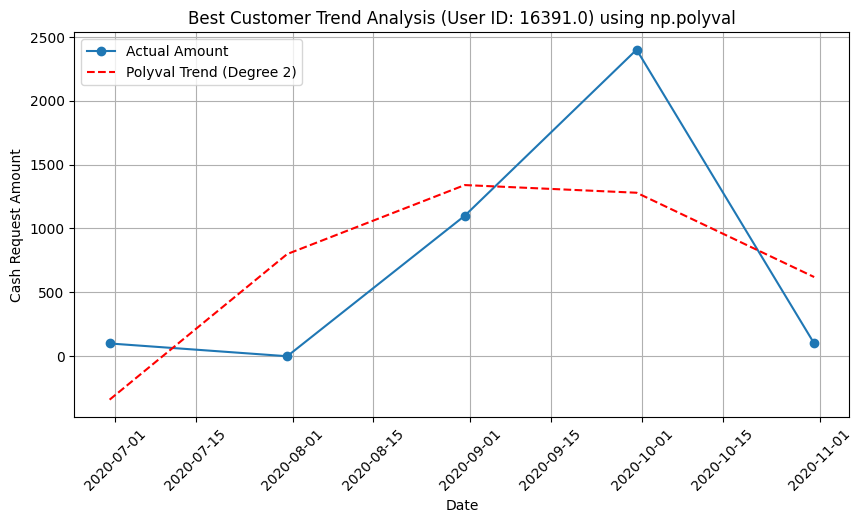

Polynomial Coefficients (y = ax^2 + bx + c):
[-300. 1440. -340.]


In [21]:
df_fees['created_at'] = pd.to_datetime(df_fees['created_at'], errors='coerce')
df_cash_request['created_at'] = pd.to_datetime(df_cash_request['created_at'], errors='coerce')

# Filter out canceled transactions
valid_cash_requests = df_cash_request[~df_cash_request['status'].str.lower().isin(['canceled', 'rejected'])]

# Merge datasets based on cash_request_id (transaction-level merge)
merged_df = df_fees.merge(valid_cash_requests, left_on='cash_request_id', right_on='id', how='inner')

# Aggregate customer statistics
customer_summary = merged_df.groupby('user_id').agg(
    total_cash_requested=('amount', 'sum'),  # Total transaction amount
    num_cash_requests=('id_y', 'count'),  # Number of transactions
    total_fees_paid=('total_amount', 'sum'),  # Total fees paid
    active_months=('created_at_x', lambda x: x.dt.to_period('M').nunique())  # Number of active months
)

# Sort customers based on highest total cash requested
best_customers = customer_summary.sort_values(by='total_cash_requested', ascending=False)

# Display top customers
print("Top Customers Based on Total Cash Requested (Excluding Canceled Transactions):")
print(best_customers.head(10))  # Display top 10 customers

# Select the best customer (highest total cash requested)
best_customer_id = best_customers.index[0]

# Filter data for the selected best customer
best_customer_data = merged_df[merged_df['user_id'] == best_customer_id]

# Display data for the selected best customer
print(f"\nBest Customer (User ID: {best_customer_id}) Transactions:")
print(best_customer_data.head())


# Select the best customer based on highest total cash requested
best_customer_id = customer_summary.sort_values(by='total_cash_requested', ascending=False).index[0]

# Prepare data for polynomial fitting
best_customer_data = best_customer_data[['created_at_x', 'amount']]  # Selecting time and amount variables
best_customer_data = best_customer_data.set_index('created_at_x').resample('M').sum()  # Aggregate monthly
best_customer_data = best_customer_data.asfreq('M', fill_value=0)  # Ensure no missing months

# Add a numeric time index
best_customer_data['month_num'] = np.arange(len(best_customer_data))

# Perform polynomial regression (degree 2 for trend)
degree = 2
coefficients = np.polyfit(best_customer_data['month_num'], best_customer_data['amount'], degree)

# Use np.polyval to compute trend values
best_customer_data['fitted_trend'] = np.polyval(coefficients, best_customer_data['month_num'])

# Plot the actual vs. fitted trend using np.polyval
plt.figure(figsize=(10, 5))
plt.plot(best_customer_data.index, best_customer_data['amount'], marker='o', linestyle='-', label='Actual Amount')
plt.plot(best_customer_data.index, best_customer_data['fitted_trend'], linestyle='--', color='red', label=f'Polyval Trend (Degree {degree})')
plt.xlabel('Date')
plt.ylabel('Cash Request Amount')
plt.title(f'Best Customer Trend Analysis (User ID: {best_customer_id}) using np.polyval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Print polynomial equation coefficients
print("Polynomial Coefficients (y = ax^2 + bx + c):")
print(coefficients)

Top Customers Based on Total Cash Requested (Excluding Canceled Transactions):
         total_cash_requested  num_cash_requests  total_fees_paid  \
user_id                                                             
16391.0                3700.0                 37            185.0   
15593.0                2800.0                 28            140.0   
3045.0                 2500.0                 25            125.0   
528.0                  2200.0                 22            110.0   
10568.0                2100.0                 21            105.0   
21934.0                2000.0                 20            100.0   
11648.0                1900.0                 19             95.0   
8649.0                 1800.0                 18             90.0   
17144.0                1750.0                 24            120.0   
13404.0                1700.0                 18             90.0   

         active_months  
user_id                 
16391.0              4  
15593.0          

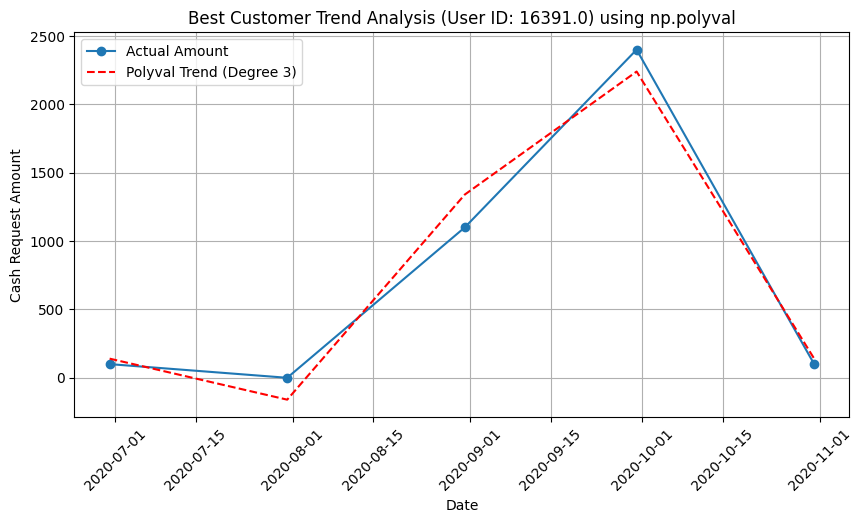

Polynomial Coefficients (y = ax^2 + bx + c):
[ -400.  2100. -2000.   140.]


In [22]:
df_fees['created_at'] = pd.to_datetime(df_fees['created_at'], errors='coerce')
df_cash_request['created_at'] = pd.to_datetime(df_cash_request['created_at'], errors='coerce')

# Filter out canceled transactions
valid_cash_requests = df_cash_request[~df_cash_request['status'].str.lower().isin(['canceled', 'rejected'])]

# Merge datasets based on cash_request_id (transaction-level merge)
outer_merged_df = df_fees.merge(valid_cash_requests, left_on='cash_request_id', right_on='id', how='outer')

# Aggregate customer statistics
customer_summary = merged_df.groupby('user_id').agg(
    total_cash_requested=('amount', 'sum'),  # Total transaction amount
    num_cash_requests=('id_y', 'count'),  # Number of transactions
    total_fees_paid=('total_amount', 'sum'),  # Total fees paid
    active_months=('created_at_x', lambda x: x.dt.to_period('M').nunique())  # Number of active months
)

# Sort customers based on highest total cash requested
best_customers = customer_summary.sort_values(by='total_cash_requested', ascending=False)

# Display top customers
print("Top Customers Based on Total Cash Requested (Excluding Canceled Transactions):")
print(best_customers.head(10))  # Display top 10 customers

# Select the best customer (highest total cash requested)
best_customer_id = best_customers.index[0]

# Filter data for the selected best customer
best_customer_data = merged_df[merged_df['user_id'] == best_customer_id]

# Display data for the selected best customer
print(f"\nBest Customer (User ID: {best_customer_id}) Transactions:")
print(best_customer_data.head())


# Select the best customer based on highest total cash requested
best_customer_id = customer_summary.sort_values(by='total_cash_requested', ascending=False).index[0]

# Prepare data for polynomial fitting
best_customer_data = best_customer_data[['created_at_x', 'amount']]  # Selecting time and amount variables
best_customer_data = best_customer_data.set_index('created_at_x').resample('M').sum()  # Aggregate monthly
best_customer_data = best_customer_data.asfreq('M', fill_value=0)  # Ensure no missing months

# Add a numeric time index
best_customer_data['month_num'] = np.arange(len(best_customer_data))

# Perform polynomial regression (degree 2 for trend)
degree = 3
coefficients = np.polyfit(best_customer_data['month_num'], best_customer_data['amount'], degree)

# Use np.polyval to compute trend values
best_customer_data['fitted_trend'] = np.polyval(coefficients, best_customer_data['month_num'])

# Plot the actual vs. fitted trend using np.polyval
plt.figure(figsize=(10, 5))
plt.plot(best_customer_data.index, best_customer_data['amount'], marker='o', linestyle='-', label='Actual Amount')
plt.plot(best_customer_data.index, best_customer_data['fitted_trend'], linestyle='--', color='red', label=f'Polyval Trend (Degree {degree})')
plt.xlabel('Date')
plt.ylabel('Cash Request Amount')
plt.title(f'Best Customer Trend Analysis (User ID: {best_customer_id}) using np.polyval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Print polynomial equation coefficients
print("Polynomial Coefficients (y = ax^2 + bx + c):")
print(coefficients)